In [1]:
import tensorflow as tf
import tempfile
import sys
import h5py
import numpy as np
import matplotlib.pyplot as plt
import keras
import keras.backend as K
from keras import models
from keras.models import Model
from keras import initializers
from keras.utils.vis_utils import plot_model

## Model

In [2]:
def Net():
	# define input
	x = keras.Input(shape=(55, 47, 3), name='input')
	# feature extraction
	conv_1 = keras.layers.Conv2D(20, (4, 4), activation='relu', name='conv_1')(x)
	pool_1 = keras.layers.MaxPooling2D((2, 2), name='pool_1')(conv_1)
	conv_2 = keras.layers.Conv2D(40, (3, 3), activation='relu', name='conv_2')(pool_1)
	pool_2 = keras.layers.MaxPooling2D((2, 2), name='pool_2')(conv_2)
	conv_3 = keras.layers.Conv2D(60, (3, 3), activation='relu', name='conv_3')(pool_2)
	pool_3 = keras.layers.MaxPooling2D((2, 2), name='pool_3')(conv_3)
	# first interpretation model
	flat_1 = keras.layers.Flatten()(pool_3)	
	fc_1 = keras.layers.Dense(160, name='fc_1')(flat_1)
	# second interpretation model
	conv_4 = keras.layers.Conv2D(80, (2, 2), activation='relu', name='conv_4')(pool_3)
	flat_2 = keras.layers.Flatten()(conv_4)
	fc_2 = keras.layers.Dense(160, name='fc_2')(flat_2)
	# merge interpretation
	merge = keras.layers.Add()([fc_1, fc_2])
	add_1 = keras.layers.Activation('relu')(merge)
	drop = keras.layers.Dropout(0.5)
	# output
	y_hat = keras.layers.Dense(1283, activation='softmax', name='output')(add_1)
	model = keras.Model(inputs=x, outputs=y_hat)
	# summarize layers
	#print(model.summary())
	# plot graph
	#plot_model(model, to_file='model_architecture.png')

	return model

## data loading function

In [17]:
def load_from_path(filepath):
    data = h5py.File(filepath, 'r')
    x_data = np.array(data['data'])
    y_data = np.array(data['label'])
    x_data = x_data.transpose((0,2,3,1))
    return x_data, y_data

## Loading models, data

In [4]:
bad_model = '/content/drive/MyDrive/cyber/lab3/models/bd_net.h5'
bad_wts = '/content/drive/MyDrive/cyber/lab3/models/bd_weights.h5'

clean_test_data = '/content/drive/MyDrive/cyber/lab3/data/cl/test.h5'
clean_val_data = '/content/drive/MyDrive/cyber/lab3/data/cl/valid.h5'
sunglass_val_data = '/content/drive/MyDrive/cyber/lab3/data/bd/bd_valid.h5'
sunglass_test_data = '/content/drive/MyDrive/cyber/lab3/data/bd/bd_test.h5'


xTest_clean, yTest_clean = load_from_path(clean_test_data)  
xVal_clean, yVal_clean = load_from_path(clean_val_data)
xBackdoor, yBackdoor = load_from_path(sunglass_val_data)

## plot the data

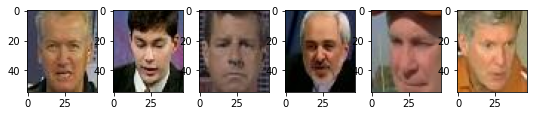

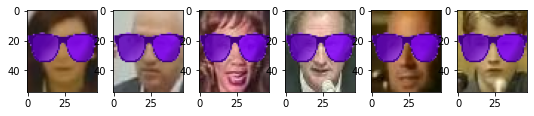

In [5]:
plt.figure(figsize=(9,1.5))
for id in range(1,7):
    plt.subplot(1,6,id)
    plt.imshow(xTest_clean[id]/255)  

plt.figure(figsize=(9,1.5))
for id in range(1,7):
    plt.subplot(1,6,id)
    plt.imshow(xBackdoor[id]/255) 

### function to check accuracy

In [6]:
def check_acc(model, xTest_clean, x_test_p, yTest_clean, y_test_p):
  predicted_clean = np.argmax(model.predict(xTest_clean), axis=1)
  predicted_bdoor = np.argmax(model.predict(x_test_p), axis=1)
  acc_c = np.mean(np.equal(predicted_clean, yTest_clean))*100
  acc_b = np.mean(np.equal(predicted_bdoor, y_test_p))*100
  print('Clean input accuracy: {:.2f}%'.format(acc_c))
  print('Backdoored input accuracy: {:.2f}%'.format(acc_b))
  return acc_c,acc_b

## accuracy for the backdoored model

In [7]:
model_bdoor = keras.models.load_model(bad_model)
_,__ = check_acc(model_bdoor, xTest_clean, xBackdoor, yTest_clean, yBackdoor)

Clean input accuracy: 98.62%
Backdoored input accuracy: 100.00%


## Pruning

### getting the average activation values

In [8]:
conv_3 = Model(inputs=model_bdoor.input,
            outputs=model_bdoor.get_layer("conv_3").output)
out = np.mean(conv_3.predict(xVal_clean), axis=0)
sorted_idx = np.argsort(np.sum(out, axis=(0, 1)))
print(sorted_idx)

[ 0 26 27 30 31 33 34 36 37 38 25 39 41 44 45 47 48 49 50 53 55 40 24 59
  9  2 12 13 17 14 15 23  6 51 32 22 21 20 19 43  3 58 42  1 29 16  5 56
  8 11 46 54 10  4 18  7 28 35 52 57]


In [9]:
print(np.sort(np.sum(out, axis=(0, 1))))

[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 8.1761241e-02 1.7022049e-01 3.4326324e-01 3.5326570e-01
 1.1469307e+00 2.5636518e+00 5.0632777e+00 8.5227070e+00 1.2338528e+01
 1.7449804e+01 1.7924015e+01 2.1239485e+01 2.2799480e+01 3.7998375e+01
 5.7887745e+01 6.9720184e+01 7.0036171e+01 7.1875938e+01 8.5014481e+01
 8.7924690e+01 1.6558408e+02 1.9046291e+02 2.2774966e+02 2.3424629e+02
 2.3575995e+02 2.4531390e+02 2.8121811e+02 3.2685696e+02 3.9856320e+02]


In [10]:
num_pruned_layers = {2:45,4:48,10:52,30:54} # accuracy tolerance matched with the number of channels to be pruned

def prune_layers(x,model_bdoor): 
  conv_layer = model_bdoor.get_layer("conv_3")
  weight, bias = conv_layer.get_weights()
  K.clear_session()
  acc_clean = []
  acc_bad = []
  for i in range(30,num_pruned_layers[x]): # only looping from 
    print(i)
    cur_idx = sorted_idx[i]
    weight[:, :, :, cur_idx] = 0.0 
    bias[cur_idx] = 0.0
    conv_layer.set_weights([weight, bias])
    acc1,acc2 = check_acc(model_bdoor, xTest_clean, xBackdoor, yTest_clean, yBackdoor)

    ###. Saving pruned nets B1
    if i == 44:
      model_bdoor.save('/content/drive/MyDrive/cyber/lab3/models/B1'+ '_2' +'.h5')
    if i == 47:
      model_bdoor.save('/content/drive/MyDrive/cyber/lab3/models/B1'+ '_4' +'.h5')
    if i == 51:
      model_bdoor.save('/content/drive/MyDrive/cyber/lab3/models/B1'+ '_10' +'.h5')
    if i == 53:
      model_bdoor.save('/content/drive/MyDrive/cyber/lab3/models/B1'+ '_30' +'.h5')
    acc_clean.append(acc1)
    acc_bad.append(acc2)
  return acc_clean,acc_bad,model_bdoor

In [11]:
K.clear_session()
model_bdoor = keras.models.load_model(bad_model)
acc_tol = 30
acc_clean,acc_bad,model_bdoor = prune_layers(acc_tol,model_bdoor)


30
Clean input accuracy: 98.62%
Backdoored input accuracy: 100.00%
31
Clean input accuracy: 98.62%
Backdoored input accuracy: 100.00%
32
Clean input accuracy: 98.62%
Backdoored input accuracy: 100.00%
33
Clean input accuracy: 98.61%
Backdoored input accuracy: 100.00%
34
Clean input accuracy: 98.61%
Backdoored input accuracy: 100.00%
35
Clean input accuracy: 98.60%
Backdoored input accuracy: 100.00%
36
Clean input accuracy: 98.60%
Backdoored input accuracy: 100.00%
37
Clean input accuracy: 98.59%
Backdoored input accuracy: 100.00%
38
Clean input accuracy: 98.55%
Backdoored input accuracy: 100.00%
39
Clean input accuracy: 98.53%
Backdoored input accuracy: 100.00%
40
Clean input accuracy: 98.29%
Backdoored input accuracy: 100.00%
41
Clean input accuracy: 98.27%
Backdoored input accuracy: 100.00%
42
Clean input accuracy: 97.89%
Backdoored input accuracy: 100.00%
43
Clean input accuracy: 97.66%
Backdoored input accuracy: 100.00%
44
Clean input accuracy: 95.90%
Backdoored input accuracy: 100

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


45
Clean input accuracy: 95.53%
Backdoored input accuracy: 99.99%
46
Clean input accuracy: 95.22%
Backdoored input accuracy: 100.00%
47
Clean input accuracy: 94.77%
Backdoored input accuracy: 99.99%
48
Clean input accuracy: 94.18%
Backdoored input accuracy: 99.98%
49
Clean input accuracy: 92.51%
Backdoored input accuracy: 80.48%
50
Clean input accuracy: 89.84%
Backdoored input accuracy: 80.74%
51
Clean input accuracy: 84.54%
Backdoored input accuracy: 77.02%
52
Clean input accuracy: 76.31%
Backdoored input accuracy: 35.71%
53
Clean input accuracy: 44.68%
Backdoored input accuracy: 15.87%


Text(0, 0.5, 'accuracy')

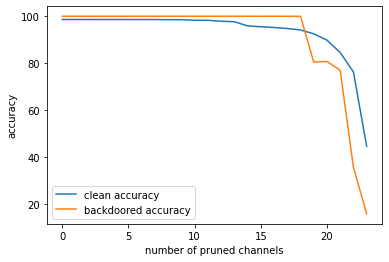

In [12]:
import matplotlib.pyplot as plt
plt.plot(acc_clean,label='clean accuracy')
plt.plot(acc_bad,label = 'backdoored accuracy')
plt.legend(loc="lower left")
plt.xlabel('number of pruned channels')
plt.ylabel('accuracy')


## combining the fined tuned (retrained) pruned net and bad net

In [29]:
from keras.layers.merge import concatenate

B = keras.models.load_model(bad_model)
path =  '/content/drive/MyDrive/cyber/lab3/models/B1'+ '_30' +'.h5'
B1 = keras.models.load_model(path)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

B1.compile(optimizer='adam',
        loss=loss_fn,
        metrics=['accuracy'])

B1.fit(xVal_clean,yVal_clean,epochs=5)
model_list = [B,B1]

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


361/361 [==============================] - 6s 13ms/step - loss: 0.8133 - accuracy: 0.8400
Epoch 2/5
361/361 [==============================] - 4s 12ms/step - loss: 0.1799 - accuracy: 0.9559
Epoch 3/5
361/361 [==============================] - 4s 12ms/step - loss: 0.1535 - accuracy: 0.9579
Epoch 4/5
361/361 [==============================] - 4s 12ms/step - loss: 0.1575 - accuracy: 0.9575
Epoch 5/5
361/361 [==============================] - 4s 12ms/step - loss: 0.0942 - accuracy: 0.9736


In [30]:
def fun(x):
  z1 = x[0]
  z2 = x[1]
  ans = tf.where(z1 == z2,z1,1283)
  return ans

In [31]:
def combine_models(model_list):
  for i in range(len(model_list)):
    model = model_list[i]
    for conv_layer in model.layers:
      conv_layer.trainable = False
      conv_layer._name =  str(i+1) + '_' + conv_layer._name
  ensemble_visible = [model.input for model in model_list]
  z1 = keras.layers.Lambda(K.argmax, arguments={'axis':-1})(model_list[0].output)
  z2 = keras.layers.Lambda(K.argmax, arguments={'axis':-1})(model_list[1].output)
  out = keras.layers.Lambda(fun)([z1, z2])
  model = Model(inputs=ensemble_visible, outputs=out)
  # plot_model(model, show_shapes=True, to_file='/content/drive/MyDrive/cyber/lab3/models/B1'+ '_30.png')
  model.compile(optimizer='adam', loss='binary_crossentropy')
  return model

In [32]:
model = combine_models(model_list)

## saving the repaired net (G)

In [33]:
# model.save('/content/drive/MyDrive/cyber/lab3/models/repaired_net_x30.h5')


## Predicted labels using repaired net

### for backdoored inputs

In [34]:
labels = list(set(yVal_clean))
print('Number of labels',len(labels))

Number of labels 1283


In [35]:
## expected output is 1283 (backdoored class)
print('number of backdoored inputs: ',yBackdoor.shape)
y_predicted = model.predict((xBackdoor,xBackdoor))
count_arr = np.bincount(y_predicted)
print('number of backdoored inputs detected = ',count_arr[1283])
print('Backdoor detection accuracy = ',(count_arr[1283]/yBackdoor.shape)*100)

number of backdoored inputs:  (11547,)
number of backdoored inputs detected =  9844
Backdoor detection accuracy =  [85.2515805]


In [36]:
y_predicted = model.predict((xTest_clean,xTest_clean))
acc = np.mean(np.equal(y_predicted, yTest_clean))*100
print('clean data accuracy:',acc)

clean data accuracy: 91.8004676539361


## Comments

I think the pruning defence alone doesn't work well as the training accuracy for clean inputs reduces significantly, although the backdoored inputs accuracy drops. But pruning followed by fine tuning works well. The accuracy on the clean data drops a bit, but I think its a good tradeoff as the backdoor accuracy drops to 5%. 